<a href="https://colab.research.google.com/github/jakejeong5007/VizWiz/blob/main/VizWiz2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://vizwiz.org/wp-content/uploads/2019/05/logo-name1.png)

In the previous week, we started our Vizwiz project and got our data ready. 
In this week, we train our own LSTM-based models. 

We'll start by visualizing our data, then identifying the best algorithm for our problem. In order to do so, we will explore a few model variants.


In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


### preparing definitions
# downloading and loading data
from keras.utils.vis_utils import plot_model
import gdown

# file variables
metadata_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/Annotations.zip'
metadata_path        = './metadata.zip'

###
gdown.download(metadata_url, './metadata.zip', True)
!unzip ./metadata.zip

# file variables
data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/small.h5'
image_data_path      = 'small.h5'

###
gdown.download(data_url, 'small.h5', True)

# file variables
train_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/train.h5'
train_path      = 'train.h5'
###
gdown.download(train_url, 'train.h5', True)

# file variables
val_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/val.h5'
val_path      = 'val.h5'

###
gdown.download(val_url, 'val.h5', True)



# file variables
data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/embedding_matrix.h5'
image_data_path      = 'embedding_matrix.h5'

###
gdown.download(data_url, 'embedding_matrix.h5', True)
embeddings_path = 'embedding_matrix.h5'



data_url         = 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/Advanced%20Topics%20in%20AI/Sessions%206%20-%2010%20(Projects)/Project%20-%20Visual%20Question%20Answering/vocab_vizwiz%20(1).json'
image_data_path      = 'vocab.json'

###
gdown.download(data_url, 'vocab.json', True)
vocab_path = 'vocab.json'


import json
import random

def get_annotations(annotations_path):
    with open(annotations_path, 'r') as f:
      metadata = json.load(f)
    return metadata

def get_random_annotation(annotations_path):
    with open(annotations_path, 'r') as f:
      metadata = json.load(f)
    i = random.choice(range(len(metadata)))
    return metadata[i]

# getting data
annotations_path = './Annotations/val.json'
vocab_path = 'vocab.json'

def get_questions(annotations_path):
  
  with open(annotations_path, 'r') as f:
    annos = json.load(f)

  questions = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    question = annos[i]['question']
    questions.add(question)

  return questions
  
from collections import Counter 
  
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 

def get_answers(annotations_path):
  with open(annotations_path, 'r') as f:
    annos = json.load(f)
  answers = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    ans = annos[i]['answers']
    answers_list = []
    for a in ans:
      answers_list += [a['answer']]
    answers.add(most_frequent(answers_list))
  return answers

def get_image_paths(annotations_path):
  with open(annotations_path, 'r') as f:
    annos = json.load(f)

  images = set()
  for i in range(len(annos)):
    if annos[i]['answerable'] == 0:
      continue
    image = annos[i]['image']
    images.add(image)

  return images

def parse_vocab(q, a):
  vocab = set()
  for qu in q:
    if '?' in qu:
      qu = qu.replace('?', '')

    vocab |= set(qu.split(' '))
  return vocab

## data and ploting
import h5py
import matplotlib.pyplot as plt

def get_data(path):
    data = h5py.File(path, 'r')
    images = data['images']
    image_idx = data['image_indices']
    questions = data['questions']
    answers = data['answers']
    return images, image_idx, questions, answers

def plot_image(img, questions=None, answers=None, indices=None):
    if indices is None:
      plt.imshow(img/255)
      plt.show()
    else:
      for i in indices:
        print('Question: ', questions[i])
        print('Answer: ', answers[i])
        plt.imshow(img[i]/255)
        plt.show()


Archive:  ./metadata.zip
   creating: Annotations/
  inflating: Annotations/val.json    
  inflating: Annotations/train.json  
  inflating: Annotations/test.json   


# Milestone 1. Understand and visualizing our data


## Activity 1a. What data do we have?


### Exercise (Coding)

We use the `get_random_annotation(annotations_path)` function to show the format of a visual question.

In [ ]:
# get a table with information about our visual questions
metadata = get_random_annotation(annotations_path)

# what does it look like?
metadata

{'answer_type': 'unanswerable',
 'answerable': 0,
 'answers': [{'answer': 'unsuitable', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'no'},
  {'answer': 'image blank', 'answer_confidence': 'yes'},
  {'answer': 'nothing', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'yes'},
  {'answer': 'unsuitable', 'answer_confidence': 'maybe'}],
 'image': 'VizWiz_val_00003248.jpg',
 'question': 'What does this say?'}

## Let's take a look at our preprocessed data!

We'll start by loading a subset of our data using `get_data`. 


`get_data` is a function that **loads** our images and visual questions

```
images, image_indices, questions, answers = get_data()
```

`images` is a numpy array of our images, with size `(number of images, 224, 224, 3)`. 

`image_indices` is a numpy array of our images indices for each q-a pair, with size `(number of q-a pairs,)`.

`questions` is a list of questions, with size `(number of q-a pairs, )`.

`answers` is a list of answers, with size `(number of q-a pairs, )`. 

**Let's try loading our data!**

In [ ]:
images, image_idx, questions, answers = get_data('small.h5')
img_idx = image_idx[0]
image = images[img_idx]
question = questions[0]
answer = answers[0]

In [ ]:
print('Our inputs are image question pairs with the output being the answer!')
print('Our image is stored as %s in Python'%type(image))
print('Our image has dimensions of (%d, %d, %d)'%image.shape)

Our inputs are image question pairs with the output being the answer!
Our image is stored as <class 'numpy.ndarray'> in Python
Our image has dimensions of (224, 224, 3)


**Visualize single data points with plot_image**

Let's see a single data point. 

`plot_image` can take in either one image or many images. To use it with one image that is 3D, call:

```
plot_image(image)
```

To use it with many images, call:


```
plot_image(images, questions, answers, indices)
```

where:
* `images`: all of our images in one array
* `questions`: the questions corresponding to the images
* `answers`: the answers corresponding to the image-question pairs
* `indices`: which images we want to see


Question:  [1.000e+00 7.470e+02 7.050e+02 1.150e+02 4.130e+02 3.470e+02 3.040e+02
 1.326e+03 5.460e+02 7.600e+02 1.081e+03 3.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
Answer:  [1.000e+00 1.496e+03 6.090e+02 3.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00]


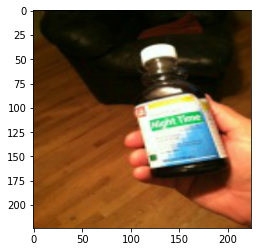

In [ ]:
# plot a SINGLE image
### YOUR CODE HERE
plot_image(images, questions, answers, [0])
### END CODE


# Milestone 2. Language only: LSTM-only model for our VQA data



## Activity 2a. Defining our machine learning problem

We explore our problem in terms of language only models. 
We train a ***bare LSTM model*** and see its performance in our data.

### Exercise (Discussion) 

What WILL our model look like? Let's define our **inputs** and **outputs**.

Will a bare LSTM model perform well on this?

In [ ]:
#@title How will our model operate? { display-mode: "form" }

#@markdown What are our inputs? 
inputs = "questions only" #@param ["images+questions", "images only", "questions only", "answers", "FillMe"]

#@markdown What are our outputs? 
outputs = "answers" #@param ["images+questions", "images", "image edges", "answers", "FillMe"]


#@markdown Will a bare LSTM do well in this task? 
problem_type  = "yes" #@param ["yes", "no", "choose answer"]


if inputs == "questions only":
  print("Yes, in this specific case our inputs are only questions!")
else:
  print('Not quite our inputs.')

if outputs == "answers":
  print("Yes, our outputs are answers!")
else:
  print('Not quite our outputs.')
  
if problem_type == "choose answer":
  print("Choose an answer por favor!")
else:
  print('Well! Let\'s train such a model and then we can answer this question.')

Yes, in this specific case our inputs are only questions!
Yes, our outputs are answers!
Well! Let's train such a model and then we can answer this question.


## Activity 2b. Building our model

As we said in the previous exercise, our data points will be composed of preprocessed questions and answers without the images. 

We now build our model.

### Exercise (Coding)


In [ ]:
#@title Run this to prepare our functions! { display-mode: "form" }


from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, LSTM, Flatten, Embedding, multiply
import h5py

def BareLSTMModel(embedding, vocab_size, q_lengths = 20, 
                  num_layers = 2, hidden_size=512, 
                  embedding_size=100, num_classes = 30,
                  dropout_rate=0.5):

  language_model = Sequential()
  language_model.add(Embedding(vocab_size, embedding_size, 
                    weights=[embedding], input_length=q_lengths, 
                    trainable=False))
  language_model.add(LSTM(hidden_size, return_sequences=True, 
                          input_shape=(q_lengths, embedding_size)))
  for i in range(num_layers-2):
      language_model.add(LSTM(hidden_size, return_sequences=True))
  language_model.add(LSTM(hidden_size, return_sequences=False))
  language_model.add(Dropout(dropout_rate))
  language_model.add(Dense(num_classes, activation='softmax'))

  return language_model


#cite Ranjay's IQ paper for code
import nltk
import re
import numpy as np
nltk.download('punkt')

class Vocabulary(object):

    def __init__(self):
        """Constructor for Vocabulary.
        """
        # Init mappings between words and ids
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word('<pad>')
        self.add_word('<start>')
        self.add_word('<end>')
        self.add_word('<unk>')

    def add_word(self, word):
        if word not in self.word2idx:
          self.word2idx[word] = self.idx
          self.idx2word[self.idx] = word
          self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def save_vocab(self, location):
        with open(location, 'w') as f:
            json.dump({'word2idx': self.word2idx,
                       'idx2word': self.idx2word,
                       'idx': self.idx}, f)

    def load_vocab(self, location):
        with open(location, 'r') as f:
            data = json.load(f)
            self.word2idx = data['word2idx']
            self.idx2word = data['idx2word']
            self.idx = data['idx']

    def decode_sentence(self, tokens):
        words = []
        for token in tokens:
            word = self.idx2word[str(token)]
            if word == '<end>':
                break
            if word not in ['<pad>', '<start>', 
                            '<end>', '<unk>']:
                words.append(word)
        return ' '.join(words)

def load_vocab(vocab_path):
    vocab = Vocabulary()
    vocab.load_vocab(vocab_path)
    return vocab

def get_embeddings(path):
  matrix = h5py.File(path, 'r')
  return matrix['embedding_matrix'][()]

from keras.utils.np_utils import to_categorical

def prepare_data(data_path):
    data = h5py.File(data_path, 'r')

    questions = data['questions'][()]
    answers = to_categorical(data['answers'][()])
    return questions, answers

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In order to build our model, we use the following function:

`BareLSTMModel(embeddings, vocab_size, embedding_dim)`

where `embeddings` is our embedding matrix, `vocab_size` is our vocabulary size and `embedding_dim` represents our embedding dimensions. 

Before we do so, we need to load our embedding matrix and our vocab.

Make sure to use `get_embeddings(embeddings_path)` to load the embedding matrix and `load_vocab(vocab_path)` for our vocab.


In [ ]:
### YOUR CODE HERE
embedding_matrix = get_embeddings(embeddings_path)
vocab = load_vocab(vocab_path)
BareLSTMModel(embedding_matrix, len(vocab), embedding_matrix.shape[1])
### END CODE

#### Visualizing our embeddings

In [ ]:
#@title Choose an index in our vocab

index = "566" #@param {type:"string"}

if int(index) < vocab.idx:
  print("Our original word is: %s"%(vocab.idx2word[index]))
  print("The given embbeding is: ", embedding_matrix[int(index)])
else:
  print("Choose an index less than %d"%vocab.idx)

Our original word is: alright
The given embbeding is:  [ 0.34696001  0.27195999  0.58310002 -0.71454    -0.25981     0.42778
  0.52034003  0.51668     0.36173001  0.17199001  0.85795999  0.44464999
  0.91334999  0.26075    -0.16007    -0.66267997 -0.61489999  0.56620002
  0.44053999  0.50572997  0.59309    -0.13132     0.22593001  0.3125
 -0.22834     0.99056    -0.10247     0.13601001  0.38708001  0.40551001
 -1.05299997 -0.038115    0.91953999  1.08080006 -0.067598    0.65171999
 -0.32633001  0.04631     0.066399   -1.39279997  0.64115     0.94349003
 -0.14767     0.30619001 -0.74065    -0.17098001 -0.32251999 -0.094326
  0.19677    -0.40817001 -0.57944    -0.40625     0.22435001 -0.075555
 -1.08959997 -0.35389999  1.38929999  0.66215998 -0.71144003  0.0090401
 -0.027667    0.74330997 -1.17470002 -0.040451    0.80282003  0.38209999
  0.44452     0.80046999 -0.2156     -0.92224002  0.77203    -0.11968
  0.37932     0.034341    0.97012001  0.27052    -0.20457     0.77065998
  0.5515099

####Let's build our model now!

Use `BareLSTMModel(embedding, len(vocab))` and make sure to specify the right parameters.

In [ ]:
### YOUR CODE HERE
model = BareLSTMModel(embedding_matrix, len(vocab), num_layers=3, dropout_rate = 0.4)
### END CODE

Let's visualize our model!

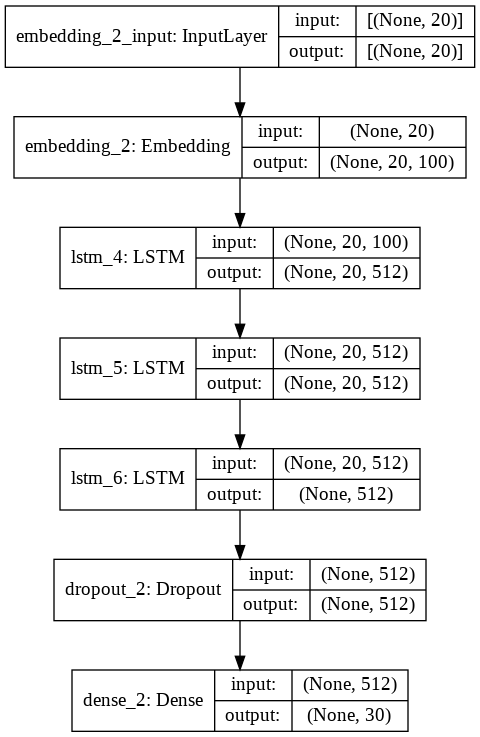

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Activity 2c. Preparing our data

With our model ready, we need to prepare our questions and answers.

In order to do so, we use the following function:

```tokenized_questions, tokenized_answers = prepare_data(train_path)```




In [ ]:
### YOUR CODE HERE
toeknized_questions, tokenized_answers = prepare_data(train_path)
### END CODE

##Activity 2d. Training our model

We built our model and prepared our data. Now, let's train our model!

We use `model.fit`.


In [ ]:
### YOUR CODE HERE
model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(toeknized_questions, tokenized_answers, batch_size = 64, epochs = 2, validation_split=0.2)
### END CODE

Epoch 1/2
59/59 [==============================] - 101s 2s/step - loss: 3.2220 - accuracy: 0.1572 - val_loss: 3.0019 - val_accuracy: 0.1358
Epoch 2/2
59/59 [==============================] - 91s 2s/step - loss: 2.4734 - accuracy: 0.2402 - val_loss: 2.1283 - val_accuracy: 0.2984


## Activity 2e. Evaluating our model

After training our model, we now evaluate it on our validation set.

We specify our validation set path in `val_path`. 

Make sure you prepare the data using the `prepare_data(path)` function and evaluate our model using `model.evaluate` 

In [ ]:
### YOUR CODE HERE
valQs, valQa = prepare_data(val_path)
model.evaluate(valQs, valQa)
### END CODE

28/28 [==============================] - 5s 191ms/step - loss: 2.0388 - accuracy: 0.3103


[2.0387589931488037, 0.3103448152542114]

Make sure to run the model with different parameters and more epochs to get better performance!

## Discussion
How good do you think the model is?

Can this model be a reliable asset for the blind?

Do you think we can do better with ***image data***? and why?

## (Optional Activity) Let's finetune our model!

Try to train our model with a different set of parameters in order to maximize our performance. 

We specify the variable that will be tuned. Make sure to change these values to improve our model!

In [ ]:
model_weights_filename = 'bareLSTM.h5'
### MAKE SURE TO CHANGE THE VARIABLES BELOW!!!
epochs = 10 # number of epochs
num_layers = 1 # number of RNN layers
hidden_size = 256 # size of each layer
batch_size = 64 # batch size
dropout_rate = 0.5 # Dropout rate
### END CODE

In [ ]:
#@title Run this to initialize and run our model! { display-mode: "form" }
### YOUR CODE HERE
embedding_dim = 100
model = BareLSTMModel(embedding_matrix, len(vocab),
                      num_layers=num_layers, 
                      hidden_size=hidden_size,
                      dropout_rate= dropout_rate)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
        metrics=['accuracy'])
model.fit(questions, answers, epochs=epochs, batch_size=batch_size, shuffle=True)
model.save_weights(model_weights_filename, overwrite=True)
### END CODE

Epoch 1/10


ValueError: ignored

# Milestone 3: Using image information in our model

After training our bare LSTM, we now use a CNN-LSTM model to answer our questions. The CNN-LSTM model encodes the information contained in the image and uses it to answer our questions.

As the information contained in the image is necessary to answer these questions, we should expect this model to do better than the previous one.

In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }


### preparing definitions
# downloading and loading data
import gdown
from keras.utils.np_utils import to_categorical


# file variables
train_feats_url         = 'https://drive.google.com/uc?id=1u485ehCP-ccAt3sSPwjCE0qCK-dOVsl5'
train_feats_path        = 'train_features.hdf5'

gdown.download(train_feats_url, 'train_features.hdf5', False)

# file variables

# file variables
val_feats_url         = 'https://drive.google.com/uc?id=1cdXPB49VuLr4ZbH-bwza9orlDddwDYOr'
val_feats_path        = 'val_features.hdf5'

gdown.download(val_feats_url, 'val_features.hdf5', False)

def encode_image(images_path, data_path):
  image_data = h5py.File(images_path, 'r')
  data = h5py.File(data_path, 'r')
  questions = data['questions'][()]
  image_features = image_data['feats'][()]
  answers = to_categorical(data['answers'][()])
  return image_features, questions, answers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Reshape
from keras import Input
from keras.layers.recurrent import LSTM
from keras.layers import concatenate
from keras.layers.merge import Concatenate
from keras.models import model_from_json, Model
from tensorflow.keras.utils import plot_model
from collections import defaultdict
import operator
from keras.utils import np_utils, generic_utils
from progressbar import Bar, ETA, Percentage, ProgressBar
from itertools import zip_longest
from keras.models import load_model

def image_model(hidden_size=512):
  image_model = Sequential()
  image_model.add(Reshape(input_shape = (4096,), target_shape=(4096,)))
  image_model.add(Dense(hidden_size, activation = 'tanh'))
  return image_model

def language_model(embedding, vocab_size, q_lengths = 20, 
                   num_layers = 2, hidden_size=512, 
                   embedding_size=100):

  language_model = Sequential()
  language_model.add(Embedding(vocab_size, embedding_size, 
                    weights=[embedding], input_length=q_lengths, 
                    trainable=False))
  language_model.add(LSTM(hidden_size, return_sequences=True, 
                          input_shape=(q_lengths, embedding_size)))
  for i in range(num_layers-2):
      language_model.add(LSTM(hidden_size, return_sequences=True))
  language_model.add(LSTM(hidden_size, return_sequences=False))

  return language_model

def vqa_model(embedding, vocab_size, q_lengths = 20, 
              num_lstm_layers = 2, hidden_size=512, 
              embedding_size=100, num_classes=30):
  image_model_ = image_model(hidden_size)

  language_model_ = language_model(embedding, vocab_size, 
                                   q_lengths = q_lengths, 
                                   num_layers = num_lstm_layers, 
                                   hidden_size=hidden_size, 
                                   embedding_size=embedding_size)
  
  combined = multiply([image_model_.output, language_model_.output])

  model = Dense(256, activation = 'tanh')(combined)
  model = Dropout(0.5)(model)

  model = Dense(256, activation = 'tanh')(model)
  model = Dropout(0.5)(model)

  model = Dense(128, activation = 'tanh')(model)
  model = Dropout(0.5)(model)

  model = Dense(num_classes)(model)
  model = Activation("softmax")(model)

  model = Model(inputs=[image_model_.input, language_model_.input], outputs=model)

  model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

  return model

Downloading...
From: https://drive.google.com/uc?id=1u485ehCP-ccAt3sSPwjCE0qCK-dOVsl5
To: /content/train_features.hdf5
76.6MB [00:00, 221MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cdXPB49VuLr4ZbH-bwza9orlDddwDYOr
To: /content/val_features.hdf5
14.3MB [00:00, 216MB/s]


## Activity 3a. Encoding our images
Instead of training a CNN model from scratch, we usually use an imagenet pretrained model in our pipeline.

This does not only improve our training marginally, but also increases the speed of our forward pass. 

Indeed, it is possible to prepare our image features in advance and only run our LSTM model after.

In order to do so, we use the following function:

```image_features, questions, answers = encode_image(train_feats_path, train_path)``` 


In [ ]:
### YOUR CODE HERE
image_features, questions, answers = encode_image(train_feats_path, train_path)
### END CODE

## Activity 3b. Training our model

Now that we have our image features ready, let's train our CNN-LSTM model.

In order to do so, we build our model using 

`model = vqa_model(embedding_matrix, vocab_size, q_lengths = 20, 
          num_lstm_layers = num_layers, hidden_size=hidden_size, embedding_size=100,
          num_classes=30)`

Make sure to specify `vocab_size`, `num_layers` and `hidden_size`.

In [ ]:
### YOUR CODE HERE
model_with_images = vqa_model(embedding_matrix, len(vocab), q_lengths = 20, num_lstm_layers = 5, hidden_size=10, embedding_size=100, num_classes=30)
### END CODE

Let's visualize our model architecture!

In [ ]:
plot_model(vqa_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

AttributeError: ignored

Let's train our model now!

Use ```vqa_model.fit([train_features, train_questions], train_answers, epochs=num_epochs, batch_size=batch_size, shuffle=True)``` to train our vqa model.

Make sure to specify `num_epochs` and `batch_size`.

In [ ]:
### YOUR CODE HERE
vqa_model.compile(optimizer='rmsprop', loss'categorical_crossentropy', metrics = ['accuracy'])
vqa_model.fit([train_featurs, train_questions], train_answers, epochs=5, batch_size=64)
### END CODE

SyntaxError: ignored

## Activity 3c. Evaluating our model
Let's evaluate our model. 

Make sure to load our validation set using

```val_features, val_questions, val_answers = encode_image(val_features_path, val_path)``` 



In [ ]:
### YOUR CODE HERE
val_features, val_questions, val_answers = encode_image(val_features_path, val_path)
### END CODE

NameError: ignored

##Activity 3d. Comparing our models predictions

### ***Discuss:*** 

Let's compare both model's performance. which of the models did better? 

Can you explain why image information is crucial in this task?

## Activity 3e. Visualizing a few examples



In [ ]:
#@title Run this to prepare data! { display-mode: "form" }
### YOUR CODE HERE
import gdown

# file variables
im_url         = 'https://drive.google.com/uc?id=1t2-Rhbts6NdDPaC64uF_Z-MHZXyCSxbX'
im_path        = 'im.zip'

gdown.download(im_url, 'im.zip', True)
!unzip im.zip

filter_url         = 'https://drive.google.com/uc?id=1Jc4Nff-5oPrjc3dwdB4eI8NZjiWT1VTJ'
filter_path        = 'filter.json'

gdown.download(filter_url, 'filter.json', True)

answers_list = json.load(open('filter.json', 'r'))

In [ ]:
#@title Choose data point to visualize? { display-mode: "form" }

inputs = "VizWiz_val_00000123.jpg" #@param ["FillMe", "VizWiz_val_00000009.jpg", "VizWiz_val_00000011.jpg", "VizWiz_val_00000028.jpg", "VizWiz_val_00000037.jpg", "VizWiz_val_00000058.jpg", "VizWiz_val_00000075.jpg", "VizWiz_val_00000084.jpg", "VizWiz_val_00000090.jpg", "VizWiz_val_00000093.jpg", "VizWiz_val_00000095.jpg", "VizWiz_val_00000100.jpg", "VizWiz_val_00000101.jpg", "VizWiz_val_00000102.jpg", "VizWiz_val_00000105.jpg", "VizWiz_val_00000114.jpg", "VizWiz_val_00000123.jpg"]

img = ["VizWiz_val_00000009.jpg", "VizWiz_val_00000011.jpg", 
       "VizWiz_val_00000028.jpg", "VizWiz_val_00000037.jpg", 
       "VizWiz_val_00000058.jpg", "VizWiz_val_00000075.jpg", 
       "VizWiz_val_00000084.jpg", "VizWiz_val_00000090.jpg", 
       "VizWiz_val_00000093.jpg", "VizWiz_val_00000095.jpg", 
       "VizWiz_val_00000100.jpg", "VizWiz_val_00000101.jpg", 
       "VizWiz_val_00000102.jpg", "VizWiz_val_00000105.jpg",
       "VizWiz_val_00000114.jpg", "VizWiz_val_00000123.jpg"]

if inputs == "FillMe":
  print("Please choose a valid data point")

index = img.index(inputs)
print(type(val_questions[index]))
print('Our question is:', vocab.decode_sentence(val_questions[index].astype(int)))
print('Our original answer is:', answers_list[val_answers[index].argmax()])

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(inputs)
plt.imshow(img)

print('Our bare LSTM model predicts:', answers_list[model.predict([val_questions[index: index + 1]]).argmax()])
print('Our VQA model predicts:', answers_list[vqa_model.predict([val_features[index:index+1], val_questions[index:index+1]]).argmax()])


In [ ]:
#@title Ask any question you want about the image { display-mode: "form" }

def encode(vocab, sentence):
    tokens = [0] * 20
    tokens[0] = vocab.word2idx['<start>']
    for i in range(min(len(sentence), 19)):
      if sentence[i] in vocab.word2idx:
        s = sentence[i]
      else:
        s = '<unk>'
      tokens[i+1] = vocab.word2idx[s]
    tokens[i+1] = vocab.word2idx['<end>']
    return np.array(tokens)


Question = "what is the color ?" #@param {type:"string"}

q = encode(vocab, Question)
print('Our bare LSTM model predicts:', answers_list[model.predict(q.reshape(1,-1)).argmax()])
print('Our VQA model predicts:', answers_list[vqa_model.predict([val_features[index:index+1], q.reshape(1,-1)]).argmax()])


# Fin! Let's analyse our model predictions in the next section!


![](https://vizwiz.org/wp-content/uploads/2019/05/logo-name1.png)